<import pandas as pd>



# Character Prediction based on Dialogue

## The One with the Introduction

Are you a Friend's *__Fanatic__*?

Could you predict who said what based on any given line?

My goal for this project was to build a model that could do just that - predict the Character that said the line!

__Background:__
__Friends__ is an American television sitcom, which aired on NBC from September 22, 1994 to May 6, 2004, lasting ten seasons. The cast included Jennifer Aniston, Courteney Cox, Lisa Kudrow, Matt LeBlanc, Matthew Perry and David Schwimmer, and the show revolved around six 20–30 something year-old friends living in Manhattan, New York City.  

The show quickly has become one of the greatest TV Shows of all time - according to TV Guide. 

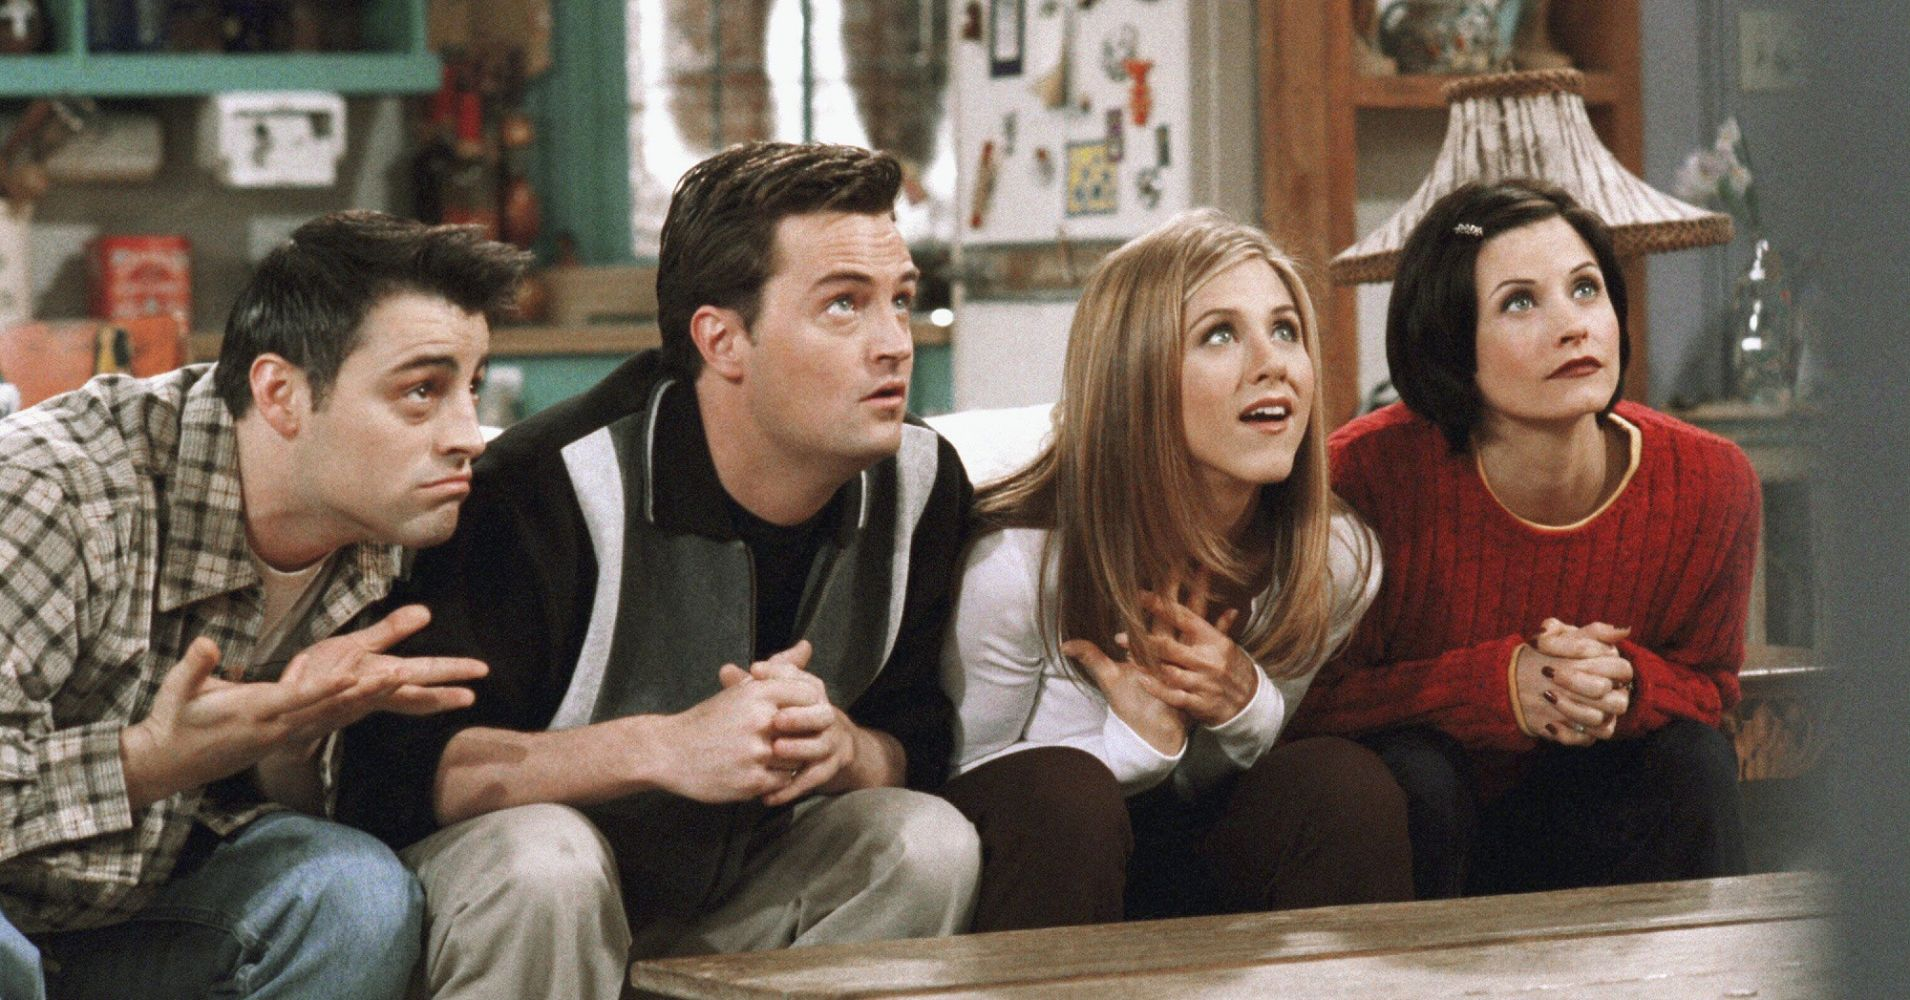

This notebook takes you through the journey I went on to see if I could build a model with a relatively good accuracy score that would predict which character said a specific line.  

## The One with all the Lines

A quick google search led me to the following website where transcripts for all 236 episodes can be [found](http://livesinabox.com/friends/scripts.shtml).
These transcripts were manually transcribed. I was challenged with scraping all of the transcripts from the site. At first, this didn't seem too difficult as I looked at the html and figured I would use a combination of tools from Beautiful Soup and regex. However, the difficulty came in when I realized that not all of the transcripts were formatted in the same way, some contained the dialogue in p tags, some in h tags and some in very unusual formats. Another google search to find a better set of transcripts led me to a [blog](http://giorasimchoni.com/2017/06/04/2017-06-04-the-one-with-friends/), where someone had scraped the transcripts but using R. How amazing was that?! While it did take some time to convert the R code to Python, the author had clearly laid out which episodes followed the same format and which episodes were irregular. 

Below is a snippet of code used to scrape:

```
#Obtain all of the URLs from the main page
all_links_url = 'http://livesinabox.com/friends/scripts.shtml'
r = requests.get(all_links_url)

#Obtain the href for each episode
url_pattern = regex.compile(r'<li><a href="(season\d+/\d+\w+.htm)')
all_episodes = regex.findall(url_pattern, r.text)

#Format the list of URLs such that it goes to an actual website
all_episodes_urls = ['http://livesinabox.com/friends/'+episode for episode in all_episodes]

#Using a for loop, iterate through each transcript and obtain the name of the character, their line(s), the title of the episode, season, and episode number.  
Characters = []
Lines = []
Title = []
Season = []
Episode = []
for url in tqdm(all_episodes_urls):
    r = requests.get(url)
    soup = BeautifulSoup(r.text,'html.parser')
    ps = soup.find_all('p')
    for p in ps:
        char = regex.findall(r"[A-Z][a-zA-Z. ]+:",p.text)
        if char != []:
            if char[0] != "Scene:":
                Characters.append(char[0])
                index = regex.search(char[0], p.text).start() + len(char[0])
                line = p.text[index:]
                Lines.append(line.replace("\n"," "))
                Title.append(soup.title.string)
                season = regex.findall('friends/(\w+\d+)', url)
                Season.append(season)
                ep = regex.findall('friends/\w+\d+/(\d+)', url)
                Episode.append(ep)
```

Once all of the episodes were scraped, I put the 5 lists (Characters, Lines, Title, Season, and Episode) into a pandas data frame and then saved it as a csv file so I could refer to it later. 

I began reviewing the data frame using some aggregation functions to determine if there were blank/missing values, null values or if anything else seemed out of place. 

```
#Determine whether there were any episodes that did not get scraped
df.groupby(['Episode']).count().sort_values(by='Line')[:5]

#Determine if any lines were picked up as blank with only '' in the row
blank_lines = df[df.Line == '']
blank_lines.groupby('Episode').count().sort_values(by='Line', ascending=False)[:10]
```

Based on the aggregation analysis performed, it would seem that we need to rescrape Episodes 116, 224, 913, 302, 608, and 406 as those were the episodes with either the least amount of scraped lines or the highest amount of blank lines. However, the total episodes to rescrape (6) is immaterial to the total number of episodes (227 total, which is about 3%), therefore, I chose not to rescrape the data. 

## The One with all the Cleaning

While there isn't a template for cleaning data, since datasets come in all different shapes, there are some key steps you can take to ensure your data is exactly how you need it to be. First, I looked at ```df.head()``` to see the first 5 rows. Next, I used the following:
- ```df.info()``` - Which gave me the number of non-null entries by column and the types of data
- ```df.isnull().sum()``` - sum of all null values by column
- ```df.dropna()``` - to drop all NA or missing rows
- ```df.Character.isin(main_characters).sum()``` - Total rows/lines associated with the main characters
- ```set(df.Character)``` - To see if there were other spellings of the main character's names
- ```def name_func(char)``` - Created a name function to fix all the misspellings of main character names and label all other characters as 'Other'
- ```df.groupby('Character').count().loc[main_characters]``` - Determine if total lines across main characters is about equal and to see if there was a significant difference between the number of null lines versus the total lines there should have been

The number of null values compared to the total values there should have been was considered insignificant. Overall, everyone still had around 97/98% of their lines. 



I dropped the null lines for the main characters in addition to dropping lines for non-main characters and lines that were said at the same time by more than one main character (i.e. Joey and Monica). Even with all of that, I still had approx. 50k rows of data. 



Next, came the big task of cleaning the lines. As I reviewed the lines, I noticed that there were a lot of things picked up in the scrape that were not true dialogue such as:
- Staging directions contained in parentheses
- URL references
- various html tags contained in <>

For example: 
```
Ok. (She sits on the bed and Ross sits near her)<+i> Thank you for coming with me today.
(to Ross) Let me get you some coffee.
About 20 minutes. <font size="4">  <b> CLOSING CREDITS </b> </font>
Well, I tracked down Marcel and get this, he's healthy, he's happy, and he's right there in New York filming <i> Outbreak II - The Virus Takes Manhattan </i> .
```

Therefore, I used a series of ```regex.sub(pattern, '', line)``` to replace the "trash" with nothing and iterated through all of the lines to clean them. Once cleaned, I added them to the data frame and, again, saved it as a CSV to use later. 

## The One with the Exploration Mission

Exploratory Data Analysis (EDA) gives us a chance to understand our dataset and get a feel for underlying trends. I took this opportunity to answer some of my questions:

1. Which character had the most lines overall?
1. Which character had the most lines per season?
1. Was there a difference in the number of lines by season?
1. Salary per season for the main characters


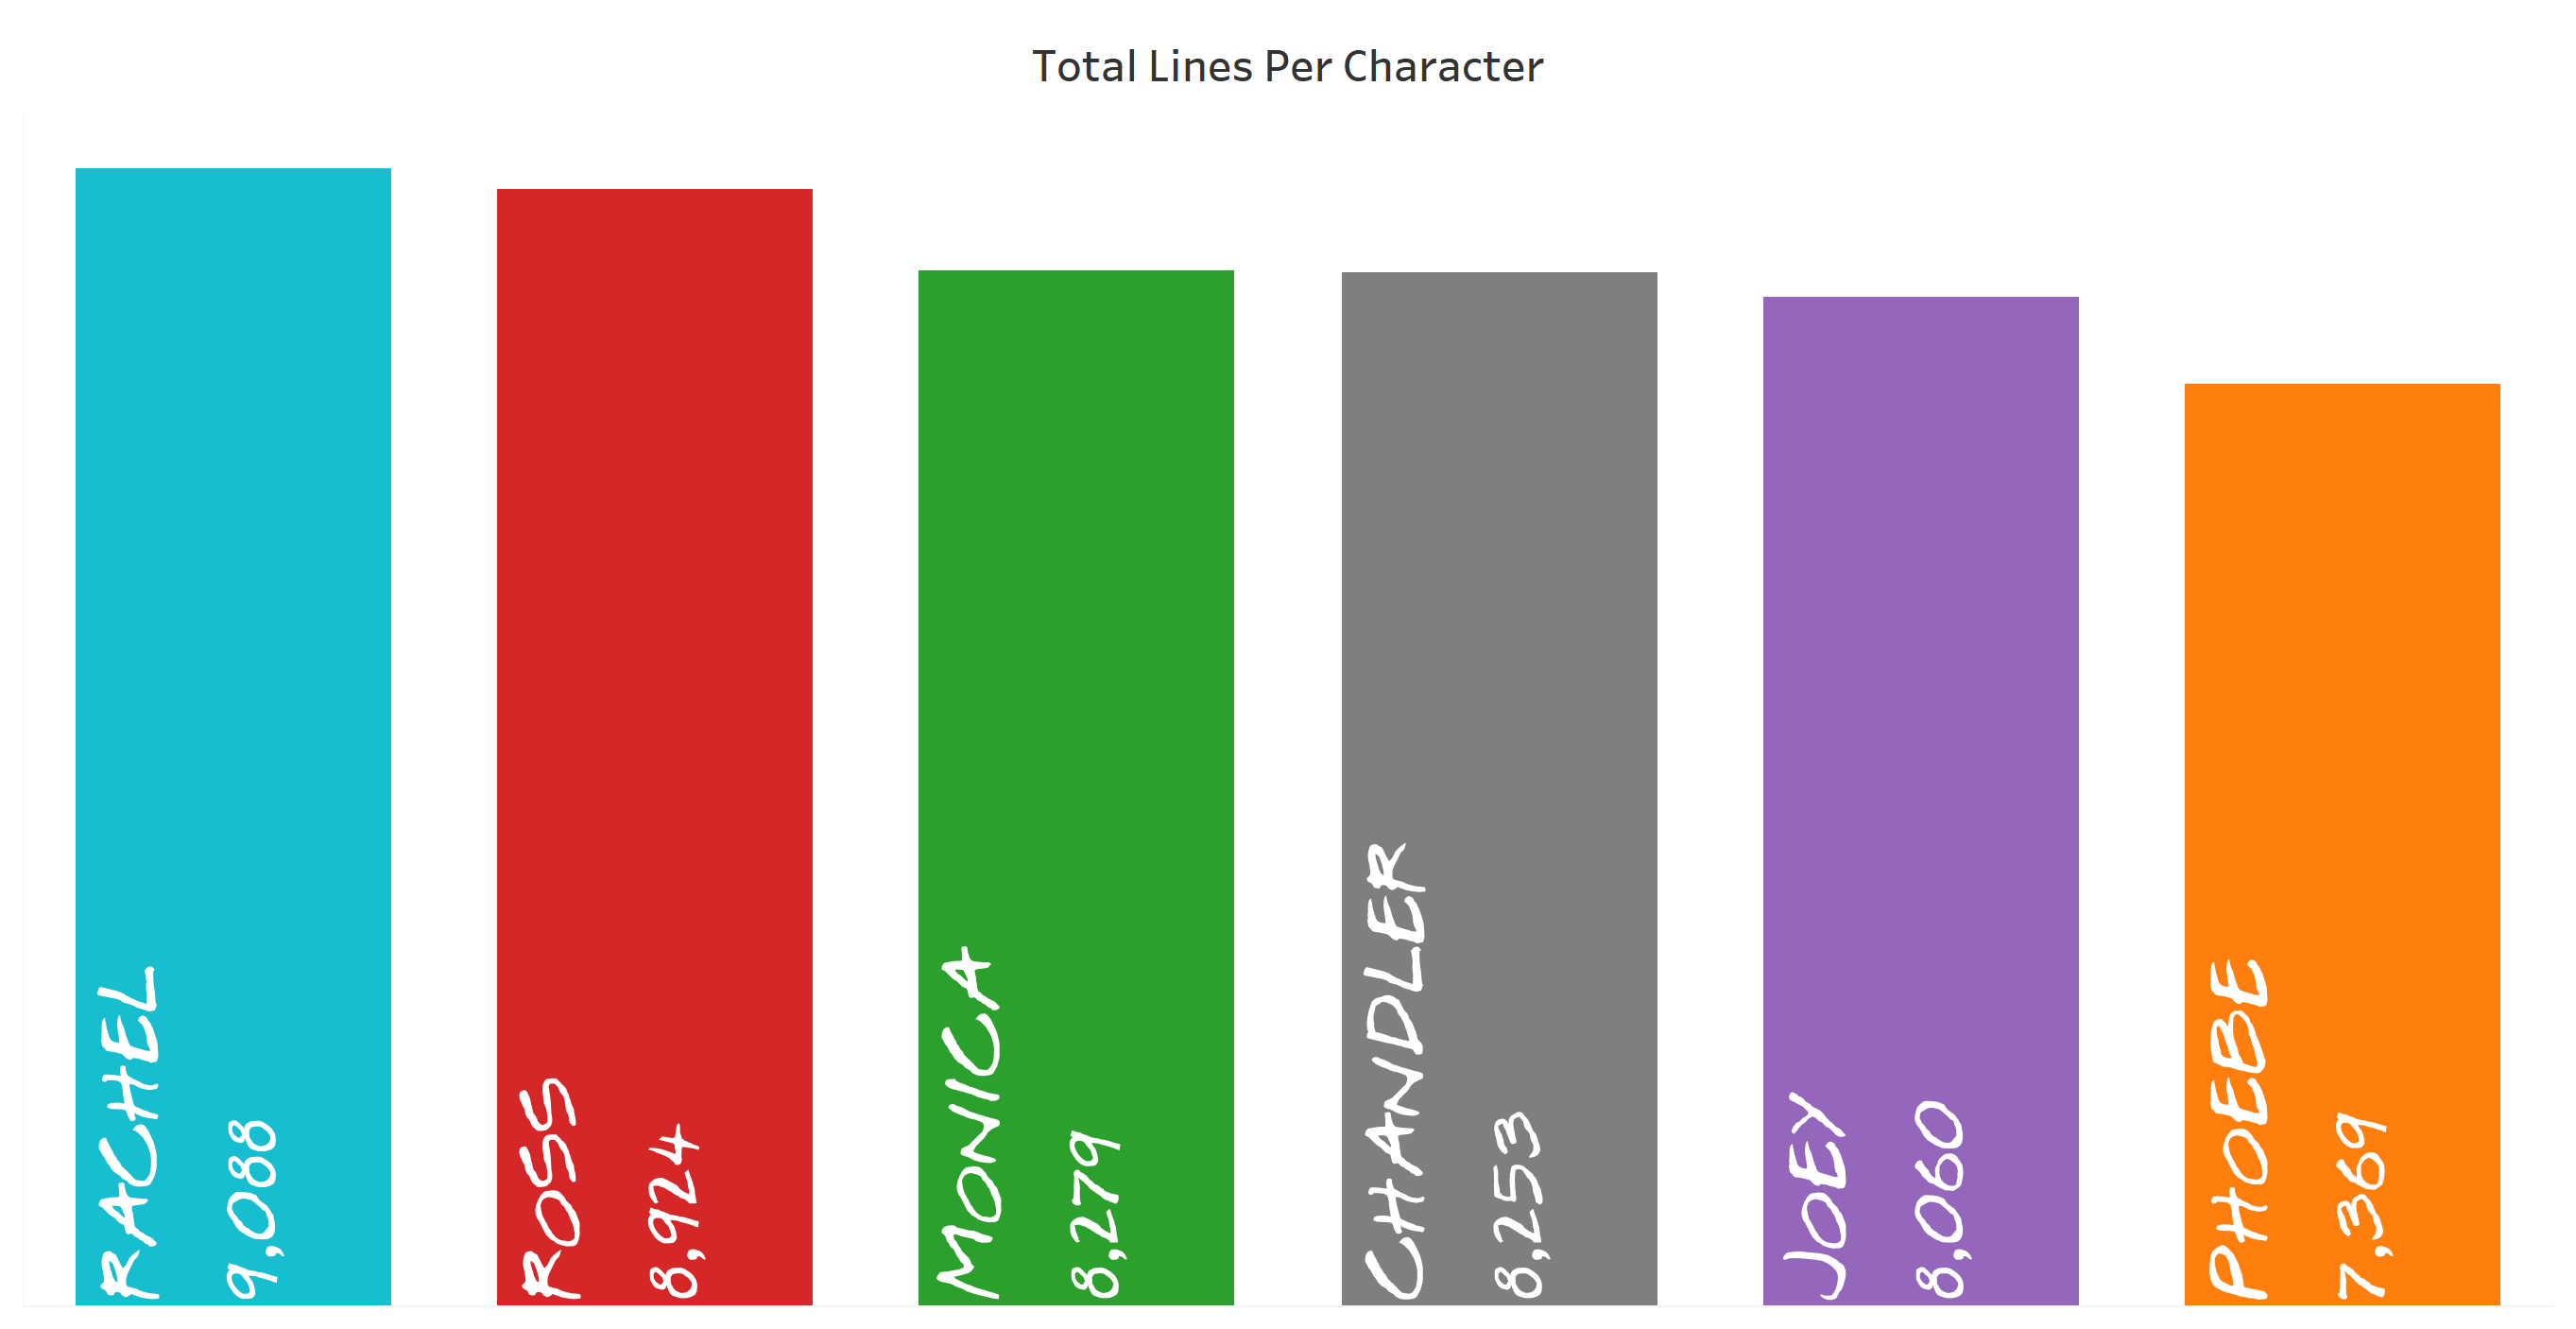

*What did I learn?*

1. Rachel had the most lines, but Ross was not far behind.

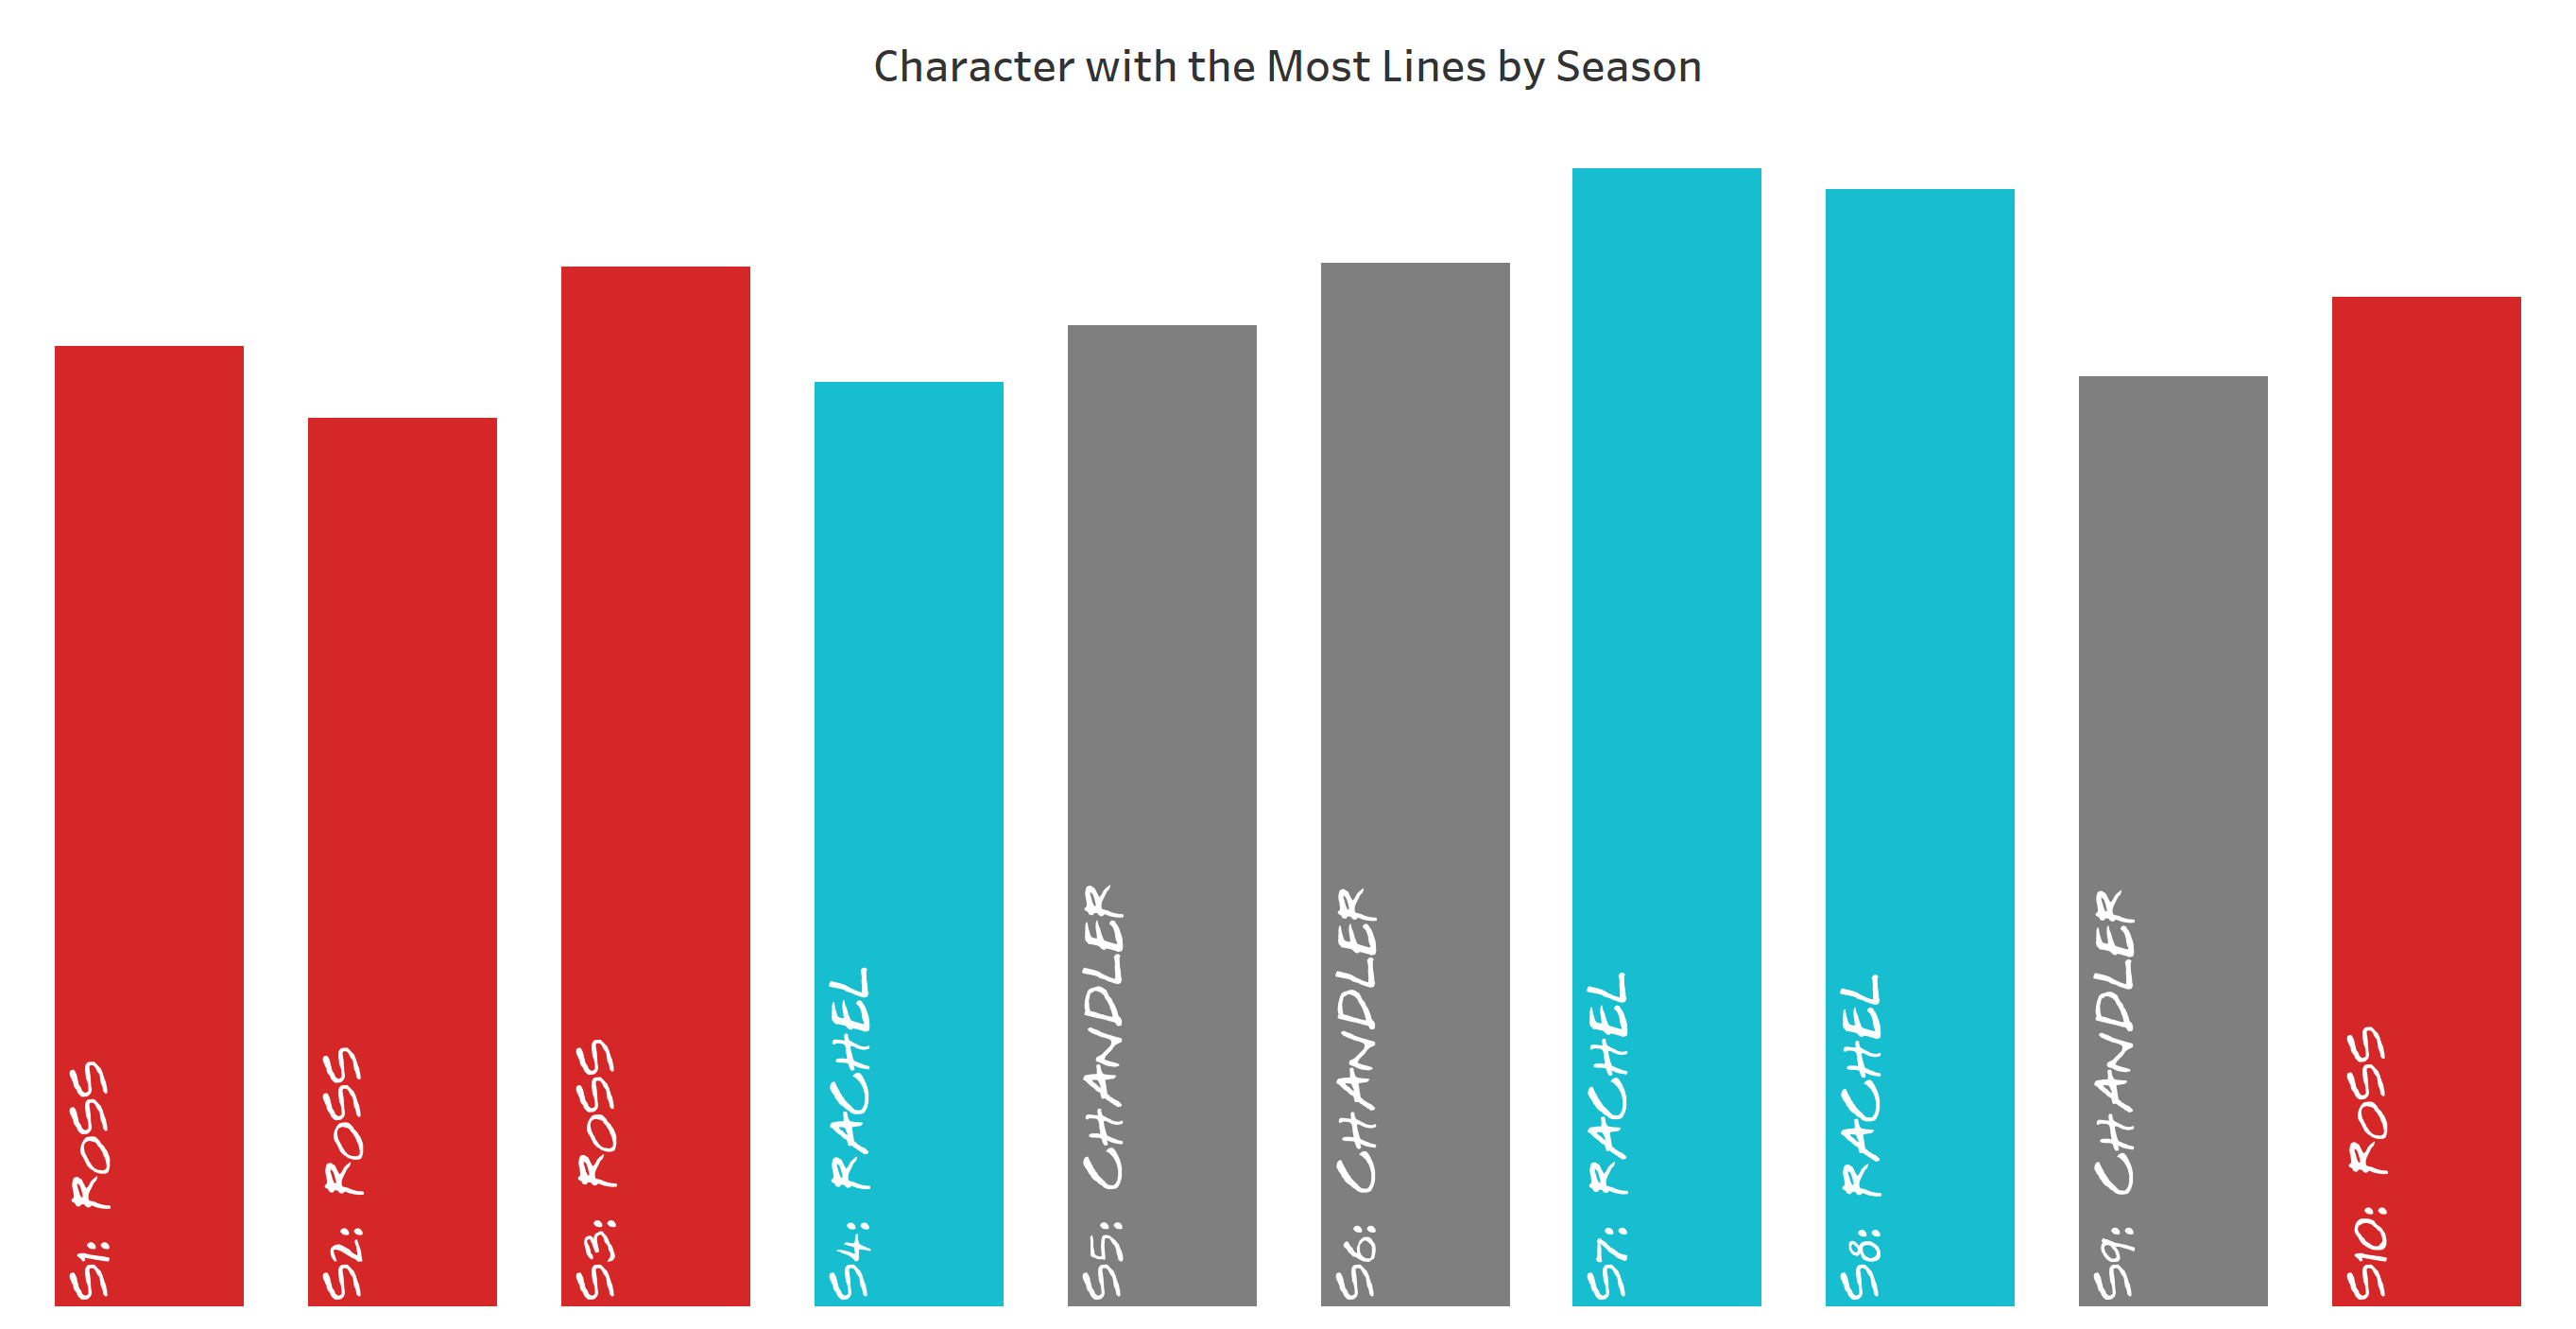

*What did I learn?*

2. Rachel, Ross and (surprisingly) Chandler had the most number of lines per season - Ross winning with the most over 4 seasons and Rachel and Chandler each with 3.

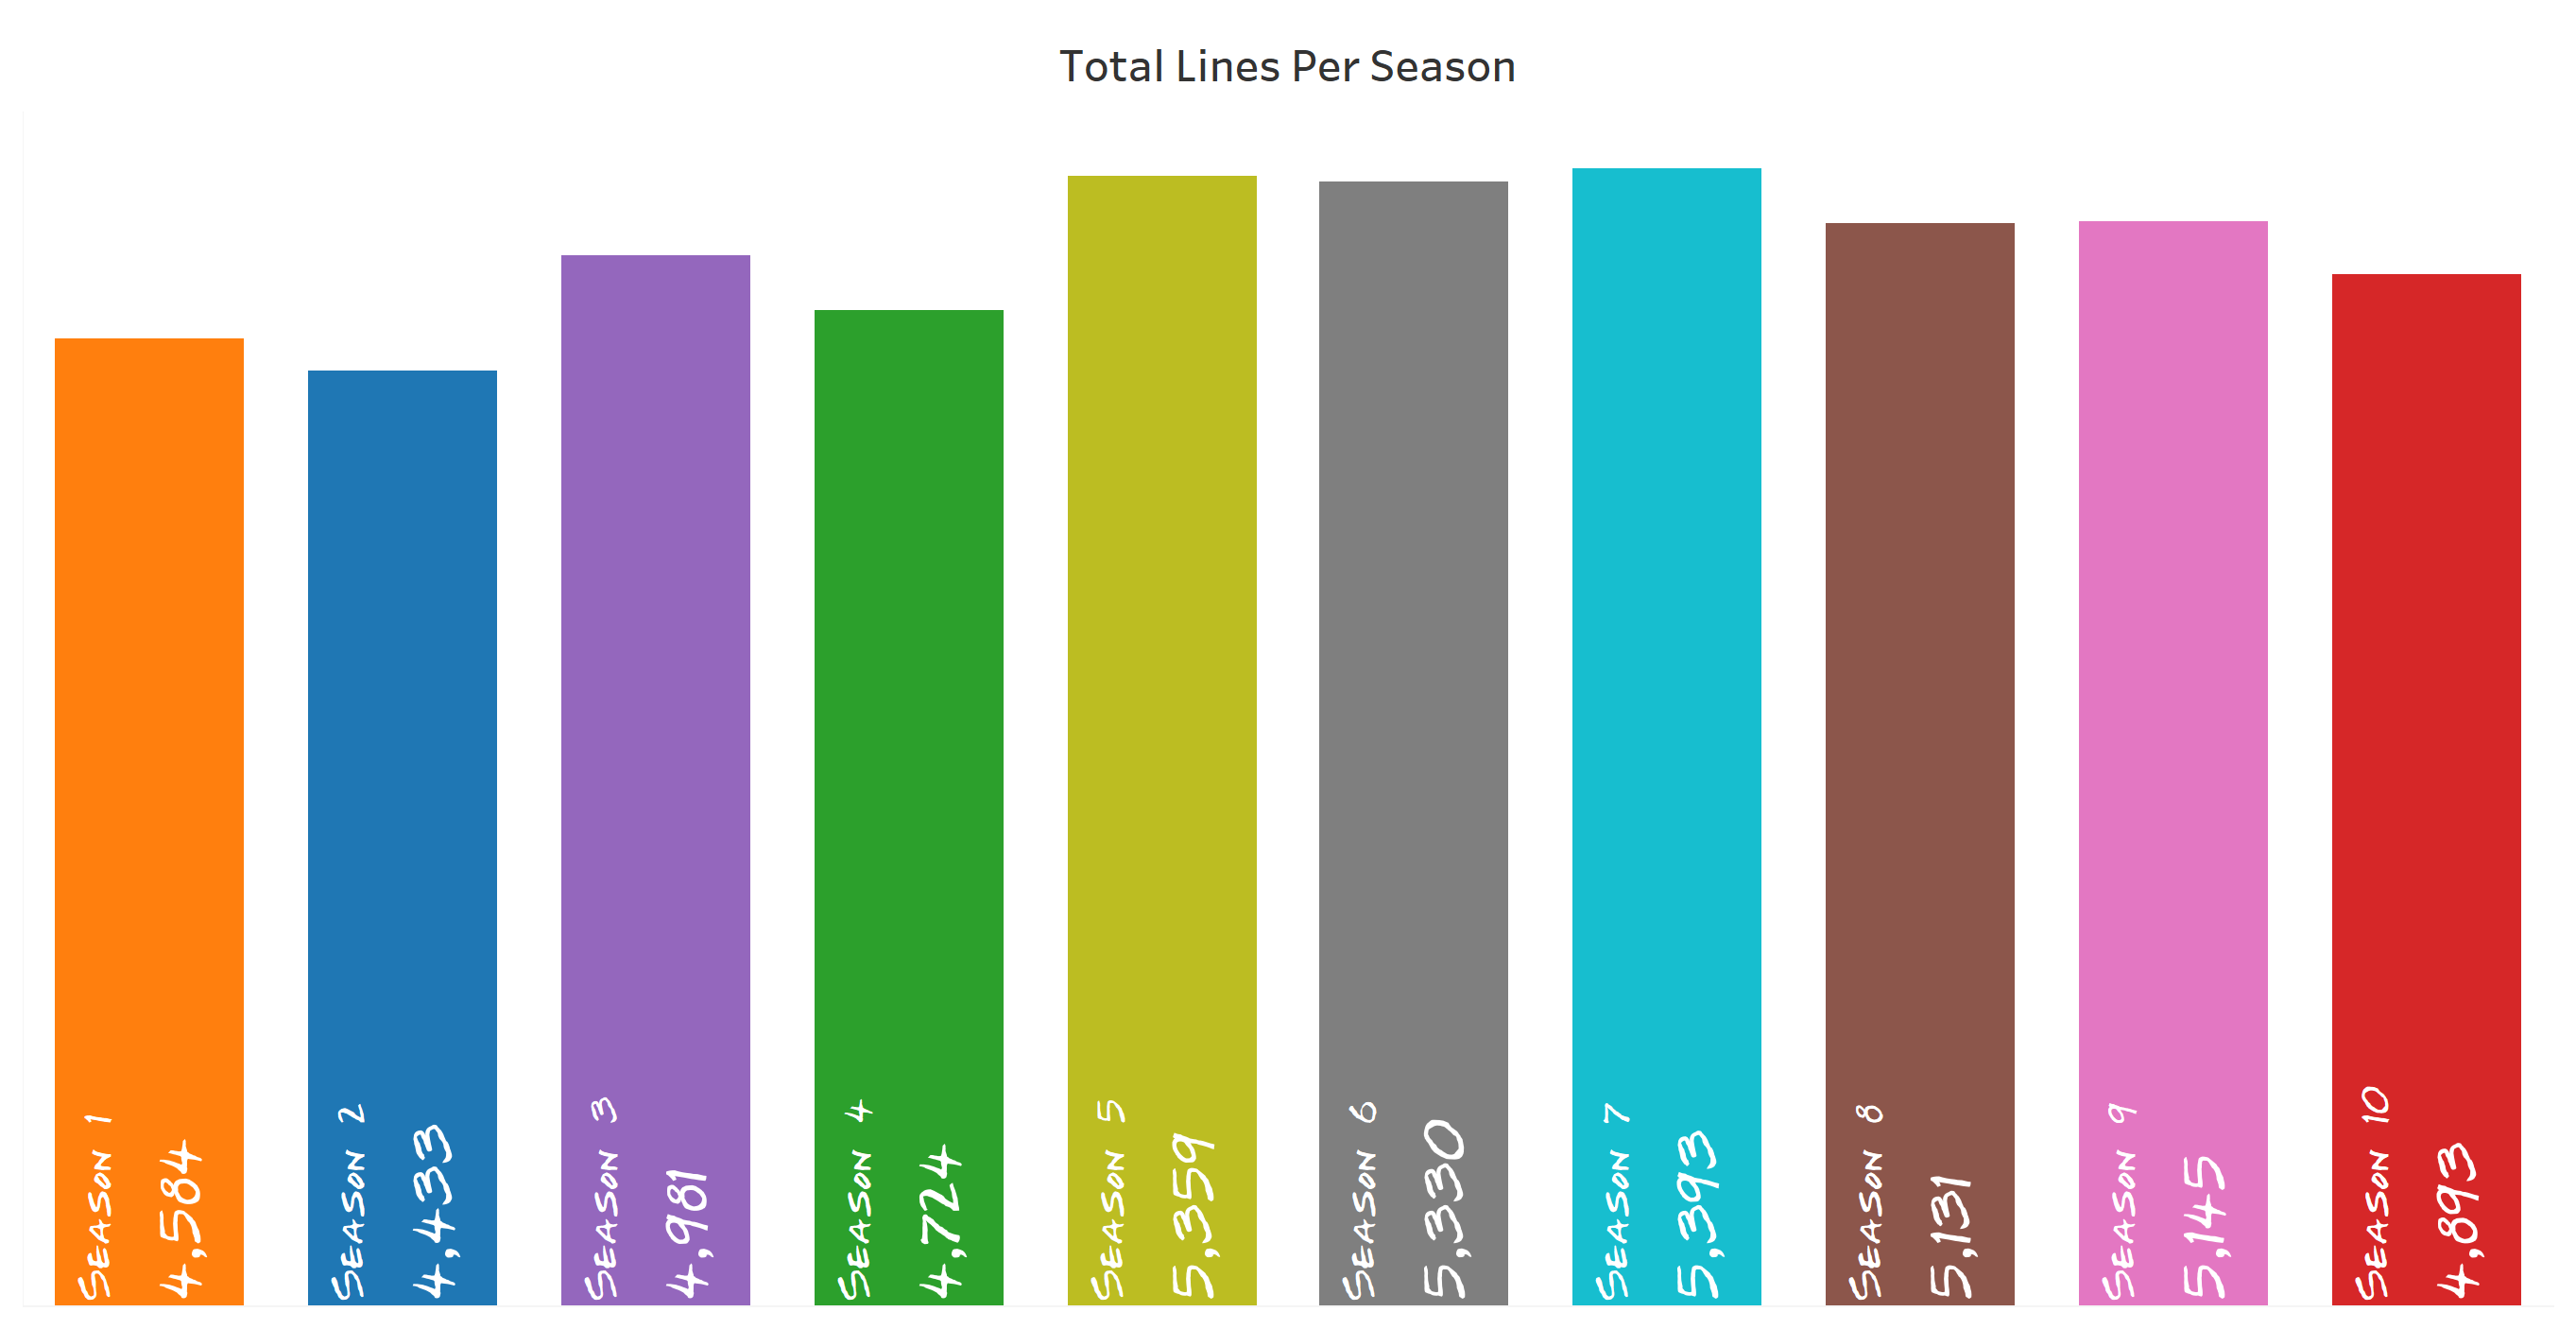

*What did I learn?*

3. There wasn't a material difference between the lines per season. I expected there to be less lines in the early seasons and more in the later seasons. Turns out I was partially right, 1-4 didn't have as many lines, there seems to be a peak in the middle seasons 5-7 and then went back down. 

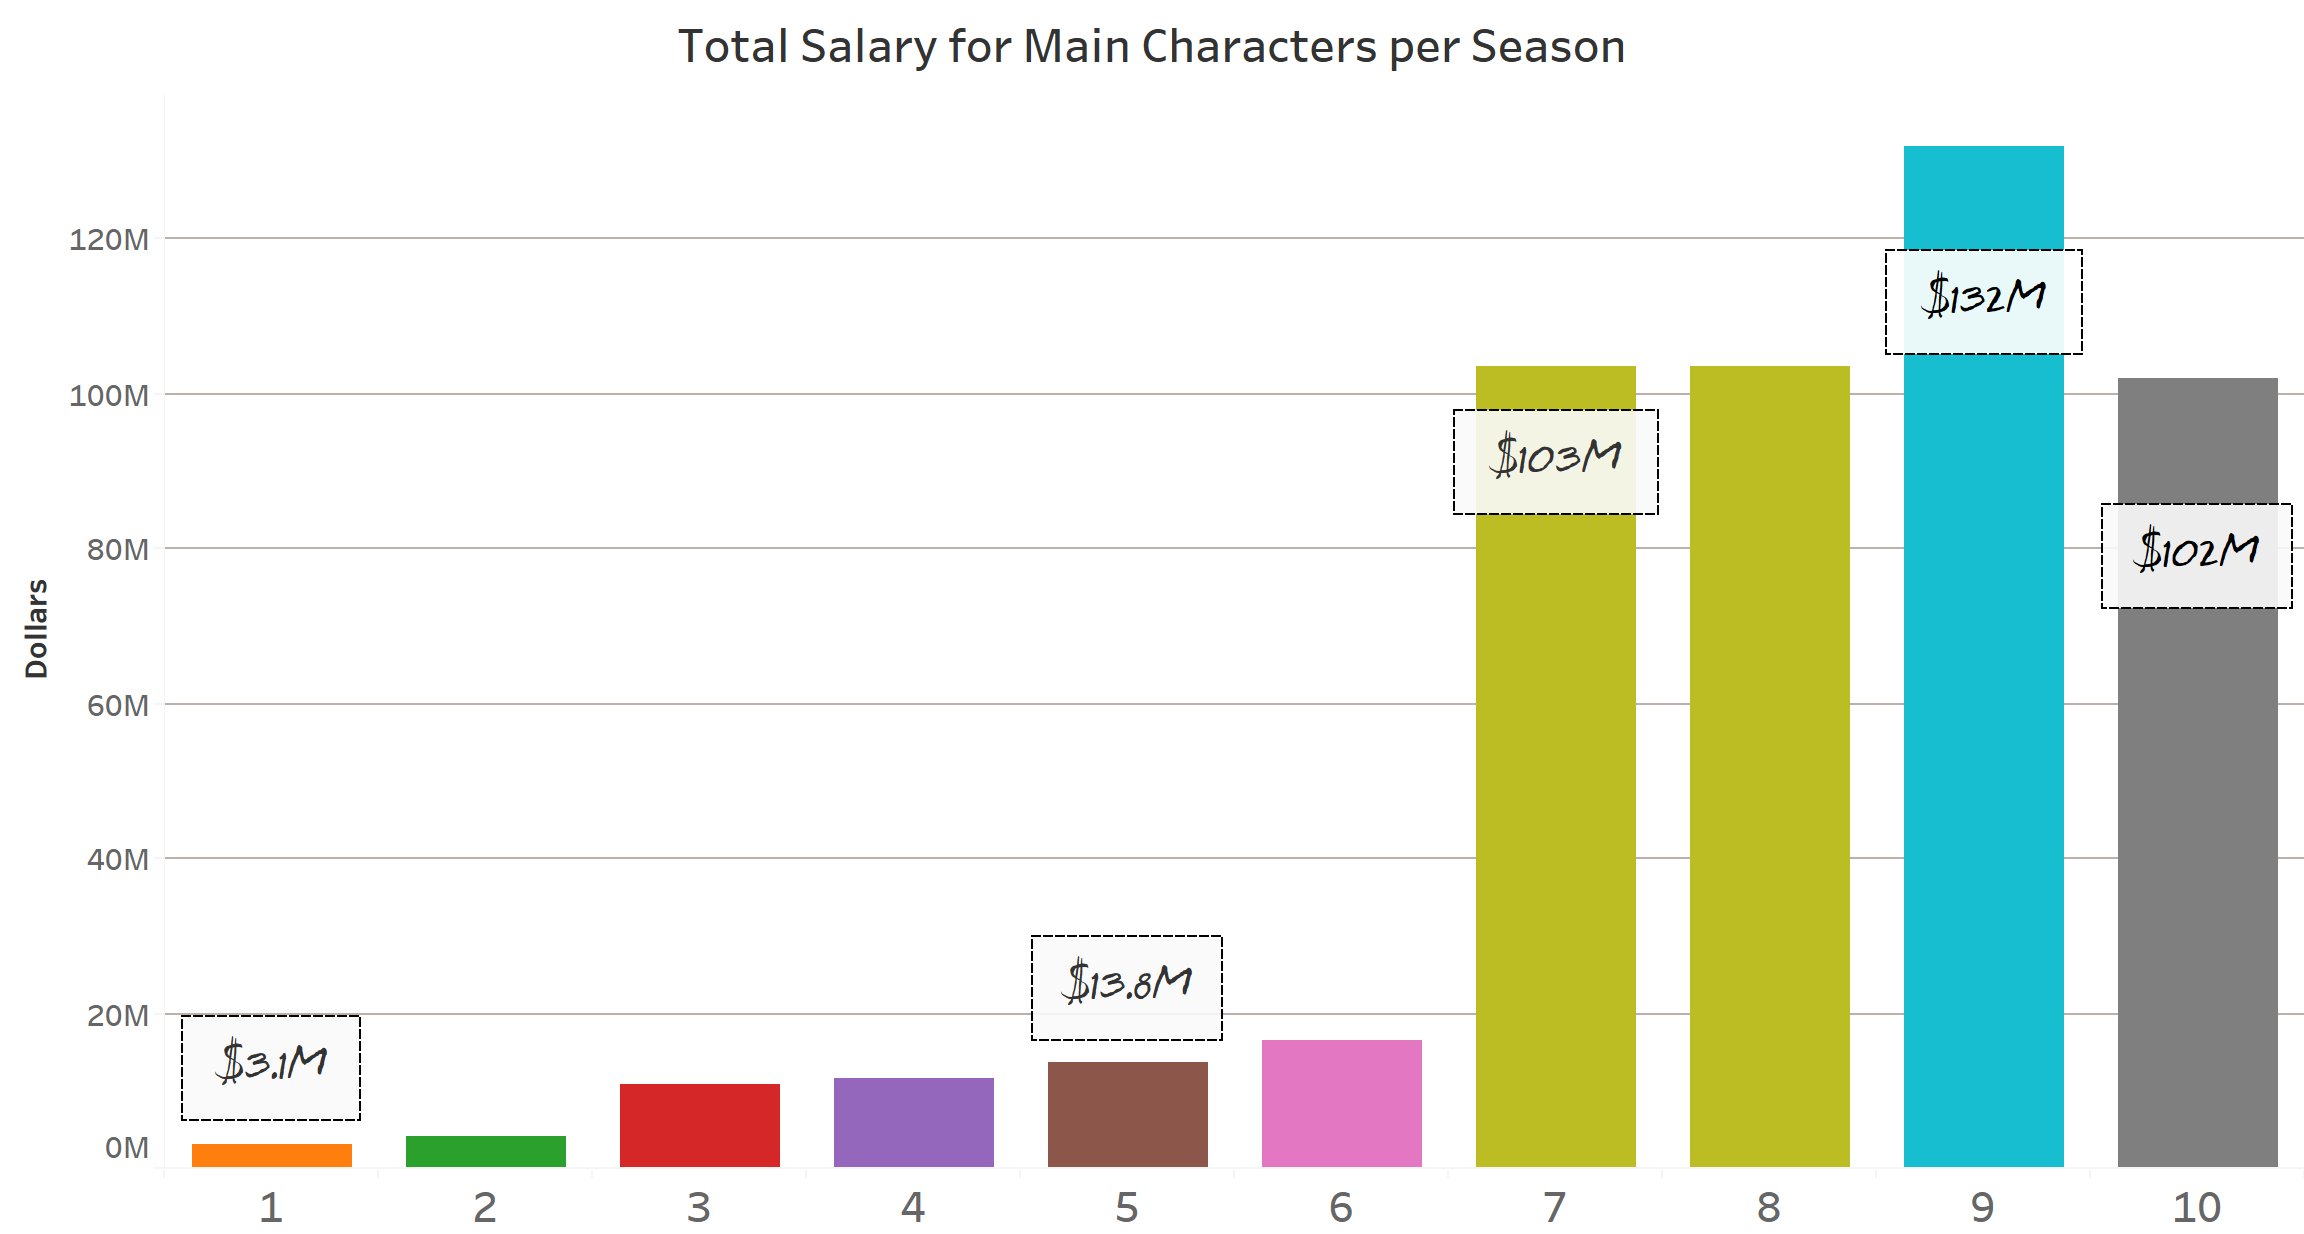

*What did I learn?*

4. I got the salary information from a [Business Insider](http://uk.businessinsider.com/how-friends-cast-got-1-million-per-episode-salary-2016-10/#david-schwimmer-and-jennifer-aniston-took-a-loss-so-they-could-band-with-their-costars-2) article, which covered the salary per episode for each of the main characters by season. The graph showed exactly what I was expecting - after the first 5/6 seasons, the show became so popular that the cast was able to renegotiate their contracts for a much higher salary per episode. It was interesting to see a dip in season 10, but this is because season 9 had 24 episodes, while 10 only had 18 episodes.  

Although the EDA was helpful in answering some trivial questions and ensuring that I had all a complete and accurate set of data, it didn't really help me answer whether I would be able to accurately predict character based on dialogue. No one character had more pull one way or another, all 6 characters appeared equal in distribution of lines. 

## The One with the Models

The plan for modeling was to run through a series of grid searches on several classification models using Count Vectorizer and TFIDF with varying attributes. 
I wanted to run the following models:
1. Logistic Regression
1. K Neighbors Classifier
1. Decision Tree Classifier
1. Linear SVC
1. SVC with RBF Kernel
1. Random Forest Classifier
1. Extra Trees Classifier
1. AdaBoost
1. Multinomial Naive Bayes
1. SGD Classifier

For the Count Vectorizer and TFIDF, I varied the following attributes:
1. ngram_range
1. Stop words
1. Minimum document frequency

And finally, I wanted to see if the results would change if I added in sentiment analysis. 

I quickly realized that while it would be possible to run through the models, some took several hours to complete and there were clearly some models that worked better with this dataset than others. In order to understand how the models were performing, I looked at the baseline for the dataset and the accuracy scores of each model. 

In [9]:
pd.DataFrame(data={'Character': ['Rachel','Ross', 'Monica','Chandler','Joey','Phoebe','Average'],
                   'Baseline Percent': ['18.2%','17.9%','16.6%','16.5%','16.1%','14.7%','16.7%']})

,Character,Baseline Percent
0,Rachel,18.2%
1,Ross,17.9%
2,Monica,16.6%
3,Chandler,16.5%
4,Joey,16.1%
5,Phoebe,14.7%
6,Average,16.7%


This means that if I were to randomly predict a character based on a given line, on average I would have a 16.7% chance of getting it right.

Before I got into the model, I had to pre-process my dataset, which included:
- Setting your X and Y
- Rescaling the data, as needed using Standard Scaler
- Using a train-test split to split the data for you and avoid over fitting
- Label Encoding your Y

I then proceeded to fit __ONE__ model using the following steps:
1. Instantiate a count vectorizer
>```cvec = CountVectorizer(stop_words='english', ngram_range=(1,3))```
1. Fit your cvec on your training set
>```cvec.fit(X_train)```
1. Transform your training and test set
>```X_train_cvec = cvec.transform(X_train)```
>```X_test_cvec = cvec.transform(X_test)```
1. Instantiate your classifier model
>```lr = LogisticRegression()```
1. Fit your classifier model
>```lr.fit(X_train_cvec, y_train)```
1. Test your model and obtain an R-squared score
>```lr.score(X_test_cvec, y_test)```

After I found that the first worked, I ran through over 20 models (see the results of those models below). Most worked, but a few either didn't run at all or took several hours to finish. Overall, I was able to use gridsearch to fine tune the different models to understand which parameters worked better with my dataset versus others.

In [12]:
results = pd.read_csv("Capstone Project - Results.csv")

In [13]:
results.drop(axis=1, columns=['Unnamed: 7'], inplace=True)

In [15]:
results.set_index('#', drop=True, inplace=True)

In [16]:
results

,NLP Vecotrizer,Parameter_1,Parameter_2,Sentiment Analysis?,Models,Score
#,,,,,,
1,Count Vectorizer,Stop Words,"ngram_range(1,3)",No,Logistic Regression,0.2988
2,Count Vectorizer,Stop Words,"ngram_range(1,3)",No,Linear SVC,0.272
3,TFIDF,Stop Words,"ngram_range(1,5)",No,Logistic Regression,0.2665
4,TFIDF,Stop Words,"ngram_range(1,5)",No,Linear SVC,0.26157
5,TFIDF,Stop Words,"ngram_range(3,7)",No,Logistic Regression,0.1861
6,TFIDF,Stop Words,"ngram_range(3,7)",No,Linear SVC,0.1859
7,TFIDF,Stop Words,"ngram_range(1,5)",No,SVC with RBF kernel,"Didnt Work, took too long to run"
8,TFIDF,Stop Words,"ngram_range(3,7)",No,SVC with RBF kernel,"Didnt Work, took too long to run"
9,TFIDF,Stop Words,"ngram_range(1,5)",No,Random Forest Classifier,0.2273


Here's what I learned from various models and parameters I used.

1. Count Vectorizer vs. TF-IDF
    - Overall none of the models I ran were drastically different when using CV vs. TFIDF 
    - I noticed that when I increased the ngram range, I got a lower accuracy score 
1. Gridsearch
    - While grid search is great at helping you get the best model, it is __SLOW__
    - You have to be careful when selecting the parameter ranges to search through, the larger the range, the longer it will take. Therefore, it is key to have an understanding of what the various parameters affect prior to setting the parameters. 
    - As a result, for each model I used, I read through the scikit learn documentation and got a better understanding of the parameters I was trying to tune. 
1. Modeling line by line vs. making a pipeline
    - Realized that making a pipeline is so much more efficient than trying to code line by line. Its faster and cleaner. 
    - You're able to do multiple layers of preprocessing and model your data in one chunk of code, which is scalable.
1. Principal Component Analysis
    - Given the large number of features generated from count vectorizers and tfidf, it would make sense to incorporate a dimensionality reduction attribute. Although PCA increases the speed of modeling, the problem is that you lose some information in the process. With already low accruacy levels, this just brought it down to baseline. 
    - In addition, I found that using a pipeline would help my models run just as fast. 
1. Know when to stop
    - I spent hours and days running different models, reviewing the results from my grid searches to make more informed models, but I didn't get a score that was significantly better. As a data scientist, it is important to understand the 80/20 rule and the law of diminishing returns. 
1. There are so many models out there!
    - There are several classifier models you can use and I tried a couple new ones that I had not tried in class: XG Boost and SGD Classifier. 
    - What was intimidating at first, ended up not being so bad! I read through the documentation to get an understanding of the model parameters and was able to run them. 
    - Yes there are a lot of models, but a [helpful guide](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet.png) and knowing your dataset can help you determine what model(s) you should use. 

## The One with the Results

After seeing the results of all the models, I noted that my first model gave me the best score. Using a count vectorizer with stop words and an ngram_range of 1-3, I got a score of 29.9%, which almost doubles the baseline probability of predicting the right character!

> Model: Logistic Regression   
> Preprocessor: Count Vectorizer   
    > Ngram Range: 1-3   
    > Stop Words = English   
> Accuracy Score: 0.2988   
> Number of features: 219010   

As you can see in the box plot below, the cross validation accuracy for 5 folds there was not a large variance in the accuracy scores (0.002 approximately). When I ran this against a few other models (Random Forest Classifier, Multinomial Naive Bayes, Ada Boost Clasifier, and Linear SVC), we see that Logistic regression was the clear winner. Linear SVC had a lot of variance, which meant that it was overfitting to the training data and Random Forest Classifier was the least accurate of the lot. 


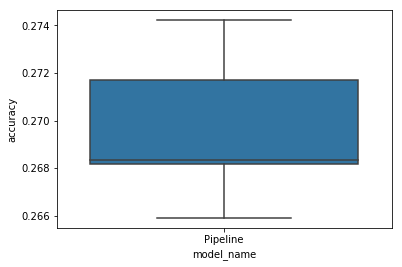
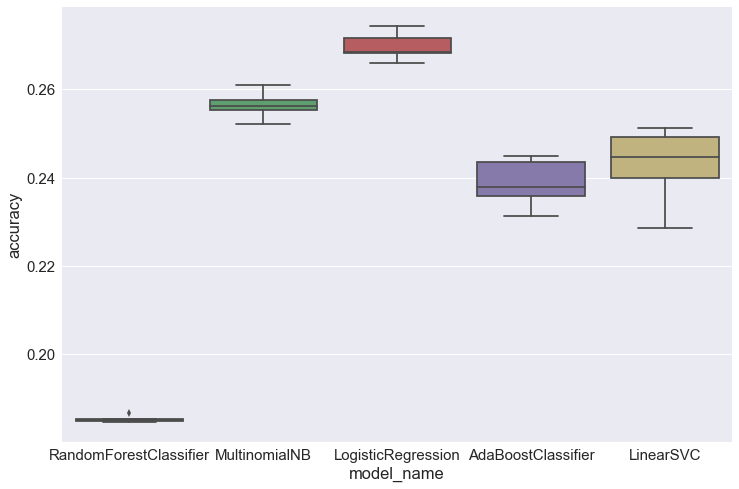

Next, I generated a confusion matrix in a heatmap (see below). Because our model did not have high accuracy, we see that our predictions are all over the place. We see very high prediction number for Rachel because she seems to be the most central character. From EDA, we saw that she had the most lines overall, that itself will give Rachel more chances of being selected. 

Phoebe seems to be the most indistinguishable, this can be because her vocabulary overlaps with other characters greatly and also, because she has the least amount of lines in the model. 

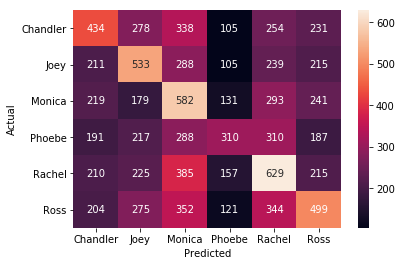

As a fan of the show, I felt like each character was so distinguishable that I should have gotten a higher score than that. I wanted to investigate further as to why I didn't. I started by generating the top unigrams and bigrams for each character and word clouds. As we can see, there is a lot of overlap with the words. 

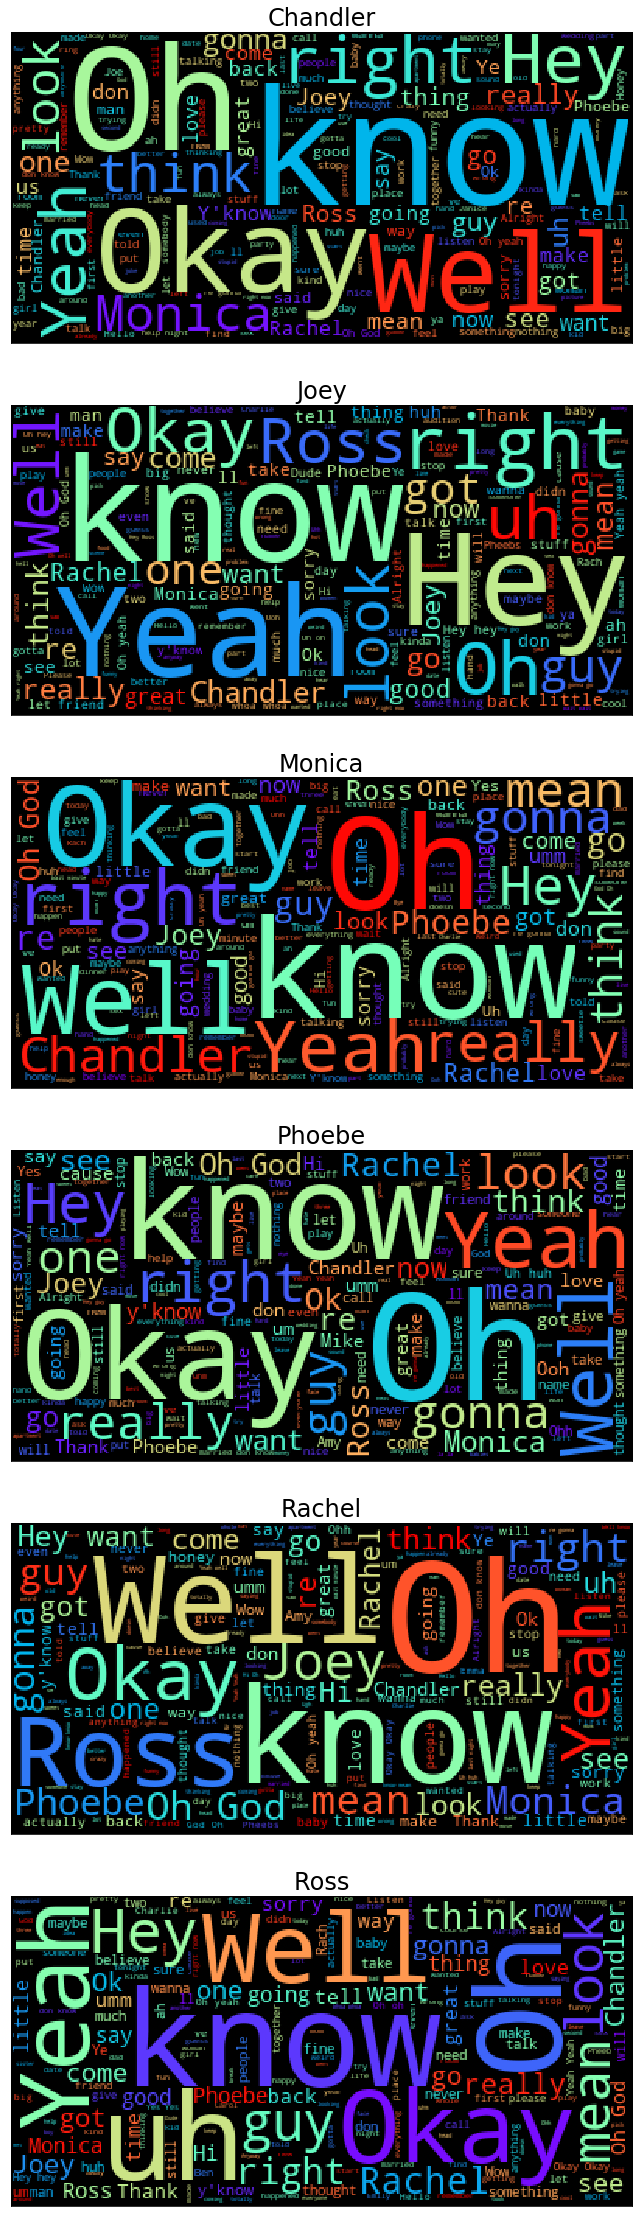
- __'Chandler':__   
  . Top unigrams:
       . joe
       . eddie
       . janice
       . babe
       . tulsa
  . Top bigrams:
       . oh come
       . chandler bing
       . big guy
       . hello children
       . oh yes
- __'Joey':__   
  . Top unigrams:
       . comin
       . dude
       . agent
       . doin
       . kate
  . Top bigrams:
       . hi joey
       . okay phoebe
       . joey tribbiani
       . pheebs sorry
       . know yeah
- __'Monica':__   
  . Top unigrams:
       . sweetie
       . pete
       . plates
       . lasagnas
       . nana
  . Top bigrams:
       . monica geller
       . god emma
       . did like
       . hey good
       . hell yeah
- __'Phoebe':__   
  . Top unigrams:
       . frank
       . mike
       . yay
       . ursula
       . massage
  . Top bigrams:
       . uh huh
       . uh hmm
       . uh joe
       . chandler monica
       . oh guy
- __'Rachel':__   
  . Top unigrams:
       . joshua
       . barry
       . ugh
       . joanna
       . tag
  . Top bigrams:
       . rachel green
       . phoebe okay
       . make stop
       . umm gonna
       . yeah sure
- __'Ross':__   
  . Top unigrams:
       . carol
       . emily
       . ben
       . correct
       . susan
  . Top bigrams:
       . ross geller
       . yes yes
       . don don
       . hey right
       . okay okay

As noted above, there is a lot of overlap see in the word clouds. If you were a Friend's expert, you could see that some of the words/ngrams are true to the personality of the character. However, there are several phrases such as "hey righ", "yeah sure", "comin" and "oh yes" that are too common to distinguish any specific character. With removal of those common phrases and further review, we could improve our model.  

## The One with the Predictions

Now that I had selected the model I wanted to use, I went ahead and started testing it. I built a classifier function (see below) that would easily return the ___word/phrase___ entered and the ___predicted character___. 

> __Function Printing Document and Assigned Class__   
```def my_classifier(my_list):```   
    ```my_pred = model.predict(my_list)```   
    ```preds = [le.classes_[pred] for pred in my_pred]```   
    ```return list(zip(my_list,preds))```
    
> __Print Function__   
```def my_printer(my):```   
```    for i in range(len(my)):```   
        print('Word/Phrase: ')   
        print(my[i][0])   
        print('Predicted Character: ')      
        print(my[i][1])   
        print()   
        


Below are some of the tested phrases and the predicted characters. They all seem to be predicting the character accurately.

> __Word/Phrase__: How you doin?   
> __Predicted Character__: Joey   

> __Word/Phrase__: We were on a break!   
> __Predicted Character__: Ross   

> __Word/Phrase__: My psychic told me Im going to die   
> __Predicted Character__: Phoebe   

> __Word/Phrase__: Ralph lauren, bloomingdales, fashion   
> __Predicted Character__: Rachel   

> __Word/Phrase__: I love having things organized and clean   
> __Predicted Character__: Monica   

> __Word/Phrase__: My father was a headliner at a gay nightclub   
> __Predicted Character__: Chandler   

I was able to take the predictions one step further and created a website where you could enter a phrase and it would return the character predicted with a picture of the character. This site was made using Flask and Bootstrap. See images of the site below.

__Input Page: Enter Phrase__ 
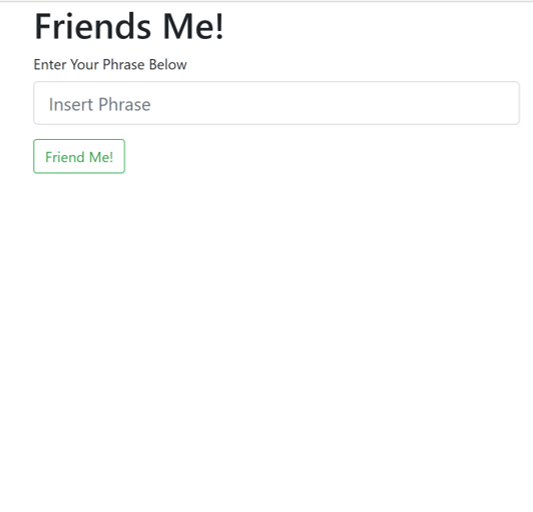

__Output Page: Predicted Character__
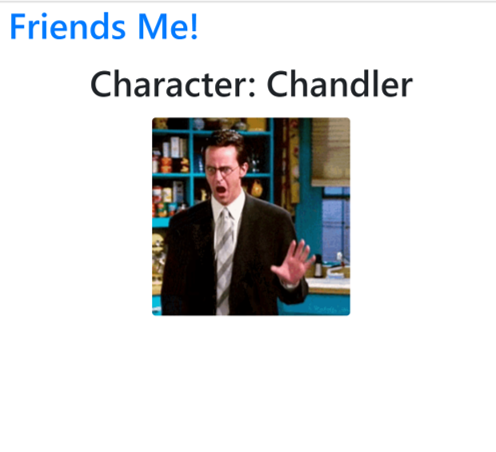

# Next Steps

Creating the basic prediction model has been a great start. Next steps in my project would include the following:
1. Determining who the central character is by looking at the Network X graphs
1. Being able to characterize a person as one of the Friend's characters based on their tweets

All in all, I set out with a goal to build a model that could predict the Character most likely to say a certain phrase and I believe I have achieved it with a relatively good accuracy score. 

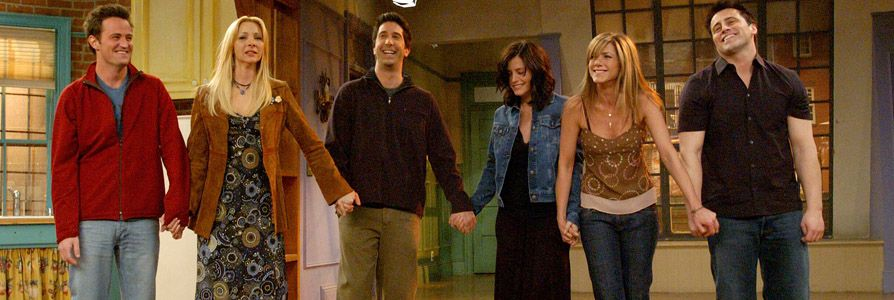